In [ ]:
# =====================================================================
# Allen Mouse Neurons — CLIP vs CLIP-SAE-ViT-L-14 (Auto-match inputs)
# =====================================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from safetensors import safe_open
from huggingface_hub import snapshot_download
from transformers import CLIPProcessor, CLIPModel
from transformers.models.clip.modeling_clip import CLIPVisionModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------------
# Config / constants
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)
print(f"Using device: {DEVICE}")

N_IMAGES = 118
N_TRIALS = 50
DATA_PATH = "/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
IMG_DIR = Path("/home/maria/MITNeuralComputation/vit_embeddings/images")
SAE_REPO = "zer0int/CLIP-SAE-ViT-L-14"
LOCAL_SAE_DIR = "./clip_sae_vitl14_weights"

# -----------------------------
# Helper: Brier
# -----------------------------
def compute_brier(y_true, y_pred, img_ids):
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    return float(np.mean((agg["p"] - agg["y"]) ** 2))

# -----------------------------
# Load neural data
# -----------------------------
dat = np.load(DATA_PATH)
print("dat shape (neurons × trials):", dat.shape)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
assert n_samples == N_IMAGES * N_TRIALS
img_ids_full = np.repeat(np.arange(N_IMAGES), N_TRIALS)

# -----------------------------
# Download SAE repo if needed
# -----------------------------
print("\n⏬ Checking/Downloading:", SAE_REPO)
snapshot_download(repo_id=SAE_REPO, local_dir=LOCAL_SAE_DIR)
print("✓ Files present.")

# -----------------------------
# Load CLIP backbone
# -----------------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
vision_model: CLIPVisionModel = clip_model.vision_model

# -----------------------------
# Find the SAE encoder weight (largest 2D tensor)
# -----------------------------
print("\n🔍 Scanning safetensors for encoder-like matrices...")
candidates = []
for f in Path(LOCAL_SAE_DIR).glob("*.safetensors"):
    with safe_open(f, framework="pt", device="cpu") as sf:
        for k in sf.keys():
            t = sf.get_tensor(k)
            if t.ndim == 2:
                candidates.append((f, k, t.shape))
                # small preview print to keep output manageable
                if t.shape[0]*t.shape[1] > 1_000_000:
                    print(f"  {f.name}: {k} shape={tuple(t.shape)}")

if not candidates:
    raise FileNotFoundError("No 2D tensors found in any .safetensors file.")

# Pick the largest area matrix as encoder weight
sae_path, enc_key, enc_shape = max(candidates, key=lambda x: x[2][0]*x[2][1])
print(f"\n→ Selected {enc_key} from {sae_path.name} with shape {enc_shape}")

# Load that weight and try to find a bias with matching out_features
with safe_open(sae_path, framework="pt", device=DEVICE) as f:
    W = f.get_tensor(enc_key)  # shape (A, B) (unknown orientation)
    # find a bias whose length matches either A or B (we'll decide orientation later)
    bias = None
    for k in f.keys():
        if "bias" in k.lower():
            b = f.get_tensor(k)
            if b.ndim == 1 and (b.shape[0] == W.shape[0] or b.shape[0] == W.shape[1]):
                bias = b
                bias_key = k
                break
if bias is None:
    # fallback to zeros; we'll set length after deciding orientation
    bias = None
print(f"Loaded encoder matrix W: {tuple(W.shape)}; bias found: {bias is not None}")

# -----------------------------
# CLIP feature extractors (four possibilities)
# -----------------------------
def feat_pooled_1024(inputs):
    # resid_post tokens -> mean over tokens -> 1024
    outs = vision_model(**inputs)
    # last_hidden_state here is after encoder: (B, T, 1024)
    # We’ll mean pool across tokens (including CLS)
    return outs.last_hidden_state.mean(dim=1)  # (B, 1024)

def feat_image_proj_768(inputs):
    # Standard CLIP projected image features (normalized), 768-dim
    feats = clip_model.get_image_features(**inputs)  # (B, 768)
    return feats

def feat_flat_resid_with_cls(inputs):
    outs = vision_model(**inputs)
    x = outs.last_hidden_state  # (B, T, 1024), CLS included (T=257)
    return x.flatten(start_dim=1)  # (B, 257*1024 = 263168)

def feat_flat_resid_no_cls(inputs):
    outs = vision_model(**inputs)
    x = outs.last_hidden_state[:, 1:, :]  # drop CLS -> (B, 256, 1024)
    return x.flatten(start_dim=1)  # (B, 256*1024 = 262144)

extractors = [
    ("pooled_1024",        feat_pooled_1024,        1024),
    ("image_proj_768",     feat_image_proj_768,      768),
    ("flat_resid_withCLS", feat_flat_resid_with_cls, 257*1024),
    ("flat_resid_noCLS",   feat_flat_resid_no_cls,   256*1024),
]

# -----------------------------
# Decide orientation + which extractor matches
# -----------------------------
def pick_mapping(W, bias):
    A, B = W.shape
    # Each extractor can match either in_features == B (W as out=A, in=B)
    # or in_features == A (W.T as out=B, in=A)
    for name, fn, dim in extractors:
        if dim == B:
            out_dim, in_dim, use_T, extractor = A, B, False, (name, fn)
            b_vec = bias if (bias is not None and bias.shape[0] == A) else torch.zeros(A, device=DEVICE)
            return out_dim, in_dim, use_T, extractor, b_vec
        if dim == A:
            out_dim, in_dim, use_T, extractor = B, A, True, (name, fn)
            b_vec = bias if (bias is not None and bias.shape[0] == B) else torch.zeros(B, device=DEVICE)
            return out_dim, in_dim, use_T, extractor, b_vec
    return None

mapping = pick_mapping(W, bias)
if mapping is None:
    raise RuntimeError(
        "Could not match encoder matrix to any known CLIP feature space.\n"
        f"Encoder shape={tuple(W.shape)}; "
        "Tried dims 768, 1024, 262144, 263168."
    )

OUT_DIM, IN_DIM, USE_T, (EXTRACTOR_NAME, EXTRACTOR_FN), B_VEC = mapping
print(f"\n✓ Matched encoder to extractor='{EXTRACTOR_NAME}' "
      f"(in_dim={IN_DIM}, out_dim={OUT_DIM}, transpose={USE_T})")

# Prepare final weight in (out_features, in_features) orientation
W_use = W.T if USE_T else W  # (OUT_DIM, IN_DIM)
if B_VEC.shape[0] != OUT_DIM:
    # ensure bias length equals out_features
    B_VEC = torch.zeros(OUT_DIM, device=DEVICE)
print(f"Final encoder weight for Linear: {tuple(W_use.shape)}, bias: {tuple(B_VEC.shape)}")

# -----------------------------
# Build encoder module
# -----------------------------
class SAEEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, W_init, b_init):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=True)
        with torch.no_grad():
            self.linear.weight.copy_(W_init)
            self.linear.bias.copy_(b_init)
    def forward(self, x):
        return torch.relu(self.linear(x))

sae = SAEEncoder(IN_DIM, OUT_DIM, W_use.to(DEVICE), B_VEC.to(DEVICE)).to(DEVICE)
sae.eval()

# -----------------------------
# Extract CLIP + SAE features for Allen images
# -----------------------------
img_paths = sorted(IMG_DIR.glob("scene_*.png"))
assert len(img_paths) == N_IMAGES, f"Expected {N_IMAGES} images, found {len(img_paths)}"
print(f"\nExtracting features using extractor='{EXTRACTOR_NAME}' ...")

# Also collect a baseline CLIP feature (1024 mean-pooled resid) for fair comparison
def baseline_clip_1024(inputs):
    outs = vision_model(**inputs)
    return outs.last_hidden_state.mean(dim=1)

clip_feats_1024, sae_feats = [], []
for p in tqdm(img_paths, desc="Feature extraction"):
    image = Image.open(p).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        x_in = EXTRACTOR_FN(inputs)             # (1, IN_DIM)
        z    = sae(x_in)                        # (1, OUT_DIM)
        x_bl = baseline_clip_1024(inputs)       # (1, 1024)
    clip_feats_1024.append(x_bl.squeeze().cpu().numpy())
    sae_feats.append(z.squeeze().cpu().numpy())

X_clip = np.stack(clip_feats_1024)   # (118, 1024) — baseline linear space
Z_sae  = np.stack(sae_feats)         # (118, OUT_DIM) — pretrained SAE space
print(f"Baseline CLIP shape: {X_clip.shape} | SAE latent shape: {Z_sae.shape}")

# -----------------------------
# Prepare trial-wise data
# -----------------------------
X_clip_full = np.repeat(X_clip, N_TRIALS, axis=0)
Z_sae_full  = np.repeat(Z_sae,  N_TRIALS, axis=0)
scaler_clip = StandardScaler().fit(X_clip_full)
scaler_sae  = StandardScaler().fit(Z_sae_full)
X_clip_full = scaler_clip.transform(X_clip_full)
Z_sae_full  = scaler_sae.transform(Z_sae_full)

# -----------------------------
# 5-Fold CV on 500 random neurons
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(N_IMAGES)))

num_neurons_to_sample = min(10, n_neurons)
sampled_neurons = rng.choice(np.arange(n_neurons), size=num_neurons_to_sample, replace=False)
print(f"\nRunning 5-fold CV on {num_neurons_to_sample} neurons...")

records = []
for i, nid in enumerate(sampled_neurons, 1):
    y_all = Y_binary[nid]
    b_clip_folds, b_sae_folds = [], []

    for train_imgs, test_imgs in folds:
        train_mask = np.isin(img_ids_full, train_imgs)
        test_mask  = np.isin(img_ids_full, test_imgs)
        Xc_train, Xc_test = X_clip_full[train_mask], X_clip_full[test_mask]
        Z_train,  Z_test  = Z_sae_full[train_mask],  Z_sae_full[test_mask]
        y_train,  y_test  = y_all[train_mask],       y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        log_clip = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_clip.fit(Xc_train, y_train)
        y_pred_clip = log_clip.predict_proba(Xc_test)[:, 1]
        b_clip = compute_brier(y_test, y_pred_clip, test_img_ids)
        b_clip_folds.append(b_clip)

        log_sae = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        b_sae = compute_brier(y_test, y_pred_sae, test_img_ids)
        b_sae_folds.append(b_sae)

    records.append({
        "neuron_idx": int(nid),
        "Brier_CLIP_mean": float(np.nanmean(b_clip_folds)),
        "Brier_CLIP_std":  float(np.nanstd(b_clip_folds)),
        "Brier_SAE_mean":  float(np.nanmean(b_sae_folds)),
        "Brier_SAE_std":   float(np.nanstd(b_sae_folds)),
        "delta_Brier_mean": float(np.nanmean(np.array(b_sae_folds) - np.array(b_clip_folds))),
        "sae_file": sae_path.name,
        "enc_key": enc_key,
        "extractor": EXTRACTOR_NAME,
        "in_dim": int(IN_DIM),
        "out_dim": int(OUT_DIM),
        "transpose_used": bool(USE_T),
    })
    if i % 50 == 0:
        print(f"  → finished {i}/{num_neurons_to_sample}")

df_cv = pd.DataFrame(records)
df_cv.to_csv("clip_sae_vitl14_auto_match_results.csv", index=False)
print("\n✅ Saved → clip_sae_vitl14_auto_match_results.csv")

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(7,5))
plt.errorbar(df_cv["Brier_CLIP_mean"], df_cv["Brier_SAE_mean"],
             xerr=df_cv["Brier_CLIP_std"], yerr=df_cv["Brier_SAE_std"],
             fmt='o', alpha=0.5)
plt.plot([0,0.3],[0,0.3],'k--')
plt.xlabel("Mean Brier (CLIP baseline, 1024)")
plt.ylabel("Mean Brier (Pretrained SAE)")
plt.title("CLIP vs CLIP-SAE-ViT-L-14 — 5-fold CV (auto-matched)")
plt.grid(True)
plt.tight_layout()
plt.savefig("clip_sae_vitl14_auto_match_plot.png", dpi=200)
plt.show()


Using device: cuda
dat shape (neurons × trials): (39209, 5900)

⏬ Checking/Downloading: zer0int/CLIP-SAE-ViT-L-14


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

✓ Files present.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



🔍 Scanning safetensors for encoder-like matrices...
  model.safetensors: text_model.embeddings.token_embedding.weight shape=(49408, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.1.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.1.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.10.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.10.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.11.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.11.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.2.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.2.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encode

Feature extraction: 100%|██████████| 118/118 [00:09<00:00, 12.55it/s]


Baseline CLIP shape: (118, 1024) | SAE latent shape: (118, 49408)

Running 5-fold CV on 10 neurons...


In [3]:
import pandas as pd

corrs=pd.read_csv('/home/maria/MITNeuralComputation/pretrained_sae/neural_finetuned_corrs_top8192_cpu.csv')

(array([  74.,  587., 2620., 5915., 9407., 9911., 6831., 3034.,  741.,
          89.]),
 array([-0.72094744, -0.57891692, -0.4368864 , -0.29485588, -0.15282536,
        -0.01079484,  0.13123567,  0.27326619,  0.41529671,  0.55732723,
         0.69935775]),
 <BarContainer object of 10 artists>)

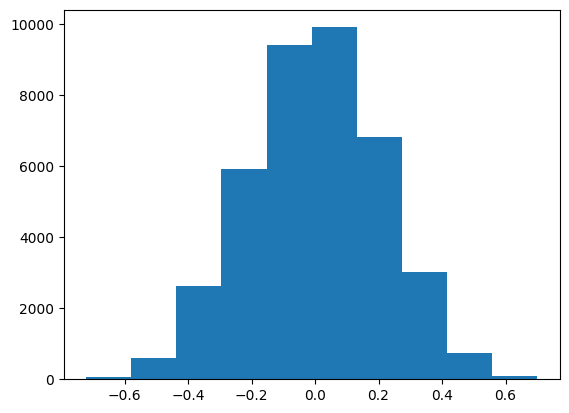

In [4]:
import matplotlib.pyplot as plt

plt.hist(corrs)

🔹 Loading model from neural_finetuned_sae_top8192_cpu.pth
✅ Data loaded: (118, 768) features, (118, 39209) responses
✅ Model loaded and ready.
✅ Mean correlation: 0.0009
🔝 Top-10 neurons by r:
 [11743  8065 33206 17731  9842  2713 24927  9993 12583 33558]
Their correlations: [0.38099757 0.35747266 0.3531997  0.3503635  0.34375462 0.34268513
 0.34163135 0.34093878 0.33209264 0.330227  ]


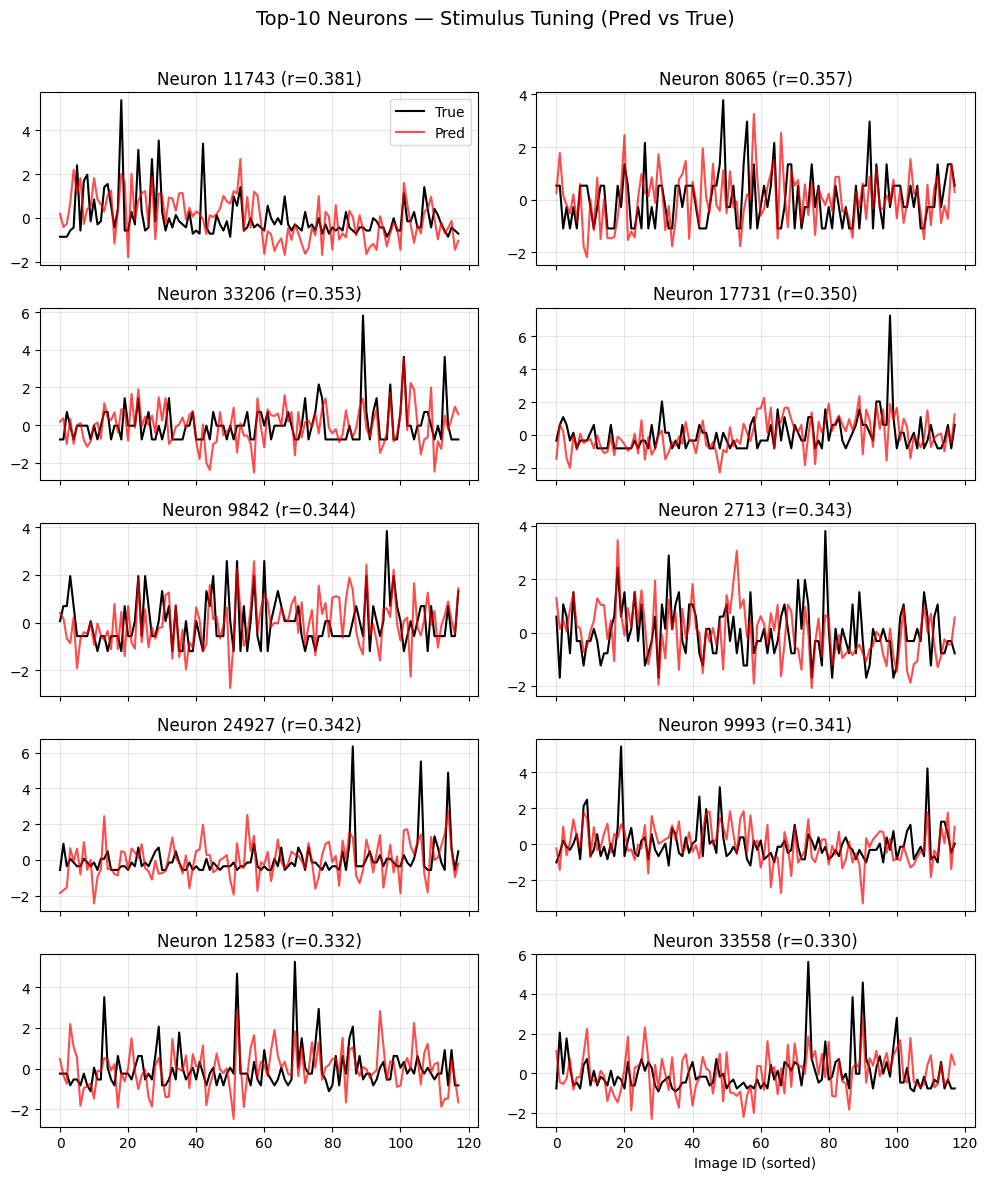

💾 Saved → top10_neuron_tuning.png


In [5]:
#!/usr/bin/env python3
# ==============================================================
#  Analyze Fine-Tuned SAE → Plot Top-10 Neurons' Stimulus Tuning
# ==============================================================

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
MODEL_PATH = "neural_finetuned_sae_top8192_cpu.pth"   # adjust to your run
CORR_PATH  = "neural_finetuned_corrs_top8192_cpu.csv" # optional saved corrs
DATA_PATH  = "/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
FEAT_PATH  = "clip_vitl14_feats.npy"

DEVICE = "cpu"
TOPK   = 8192  # must match model
LAMBDA_SPARSE = 1e-3
LAMBDA_NEURAL = 5e-2

print(f"🔹 Loading model from {MODEL_PATH}")

# ---------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------
dat = np.load(DATA_PATH)
Y_binary = (dat > 0).astype(np.float32)
n_neurons, n_samples = Y_binary.shape
N_IMAGES = 118
N_TRIALS = n_samples // N_IMAGES
img_ids_full = np.repeat(np.arange(N_IMAGES), N_TRIALS)
Y_image_mean = np.array([Y_binary[:, img_ids_full == i].mean(axis=1)
                         for i in range(N_IMAGES)], dtype=np.float32)

X_clip = np.load(FEAT_PATH).astype(np.float32)
print(f"✅ Data loaded: {X_clip.shape} features, {Y_image_mean.shape} responses")

# ---------------------------------------------------------------
# MODEL DEFINITION (must match training)
# ---------------------------------------------------------------
class SAEEncoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    def forward(self, x): return F.relu(self.linear(x))

class NeuralFineTuneSAE(nn.Module):
    def __init__(self, in_dim, out_dim, n_neurons, λs=1e-3, λn=5e-2):
        super().__init__()
        self.encoder = nn.Linear(in_dim, out_dim)
        self.neural_head = nn.Linear(out_dim, n_neurons, bias=False)
        self.λs, self.λn = λs, λn
    def forward(self, x, y=None):
        z = F.relu(self.encoder(x))
        loss_s = z.abs().mean()
        loss_n = torch.tensor(0.0)
        if y is not None:
            y_pred = self.neural_head(z)
            loss_n = F.mse_loss(y_pred, y)
        return self.λs*loss_s + self.λn*loss_n, z

# ---------------------------------------------------------------
# LOAD MODEL
# ---------------------------------------------------------------
in_dim = X_clip.shape[1]
out_dim = TOPK
n_neurons = Y_image_mean.shape[1]

model = NeuralFineTuneSAE(in_dim, out_dim, n_neurons,
                          LAMBDA_SPARSE, LAMBDA_NEURAL)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded and ready.")

# ---------------------------------------------------------------
# COMPUTE PREDICTIONS
# ---------------------------------------------------------------
X_t = torch.tensor(X_clip)
with torch.no_grad():
    _, z = model(X_t)
    Y_pred = model.neural_head(z).cpu().numpy()
Y_true = Y_image_mean

# ---------------------------------------------------------------
# PER-NEURON CORRELATIONS
# ---------------------------------------------------------------
corrs = []
for i in range(n_neurons):
    xi, yi = Y_pred[:, i], Y_true[:, i]
    if np.std(xi) < 1e-8 or np.std(yi) < 1e-8:
        corrs.append(np.nan)
    else:
        corrs.append(pearsonr(xi, yi)[0])
corrs = np.array(corrs)
mean_corr = np.nanmean(corrs)
print(f"✅ Mean correlation: {mean_corr:.4f}")

# ---------------------------------------------------------------
# TOP-10 NEURONS BY CORR
# ---------------------------------------------------------------
top_idx = np.argsort(corrs)[-10:][::-1]
print("🔝 Top-10 neurons by r:\n", top_idx)
print("Their correlations:", corrs[top_idx])

# ---------------------------------------------------------------
# PLOT STIMULUS TUNING (Pred vs True)
# ---------------------------------------------------------------
fig, axs = plt.subplots(5, 2, figsize=(10, 12), sharex=True)
axs = axs.flatten()

for j, nid in enumerate(top_idx):
    ax = axs[j]
    yt = Y_true[:, nid]
    yp = Y_pred[:, nid]
    yt_z = (yt - yt.mean()) / (yt.std() + 1e-6)
    yp_z = (yp - yp.mean()) / (yp.std() + 1e-6)
    ax.plot(yt_z, label="True", color="black", linewidth=1.5)
    ax.plot(yp_z, label="Pred", color="red", alpha=0.7)
    ax.set_title(f"Neuron {nid} (r={corrs[nid]:.3f})")
    ax.grid(True, alpha=0.3)
    if j == 0: ax.legend()

plt.suptitle("Top-10 Neurons — Stimulus Tuning (Pred vs True)", fontsize=14)
plt.xlabel("Image ID (sorted)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("top10_neuron_tuning.png", dpi=200)
plt.show()

print("💾 Saved → top10_neuron_tuning.png")


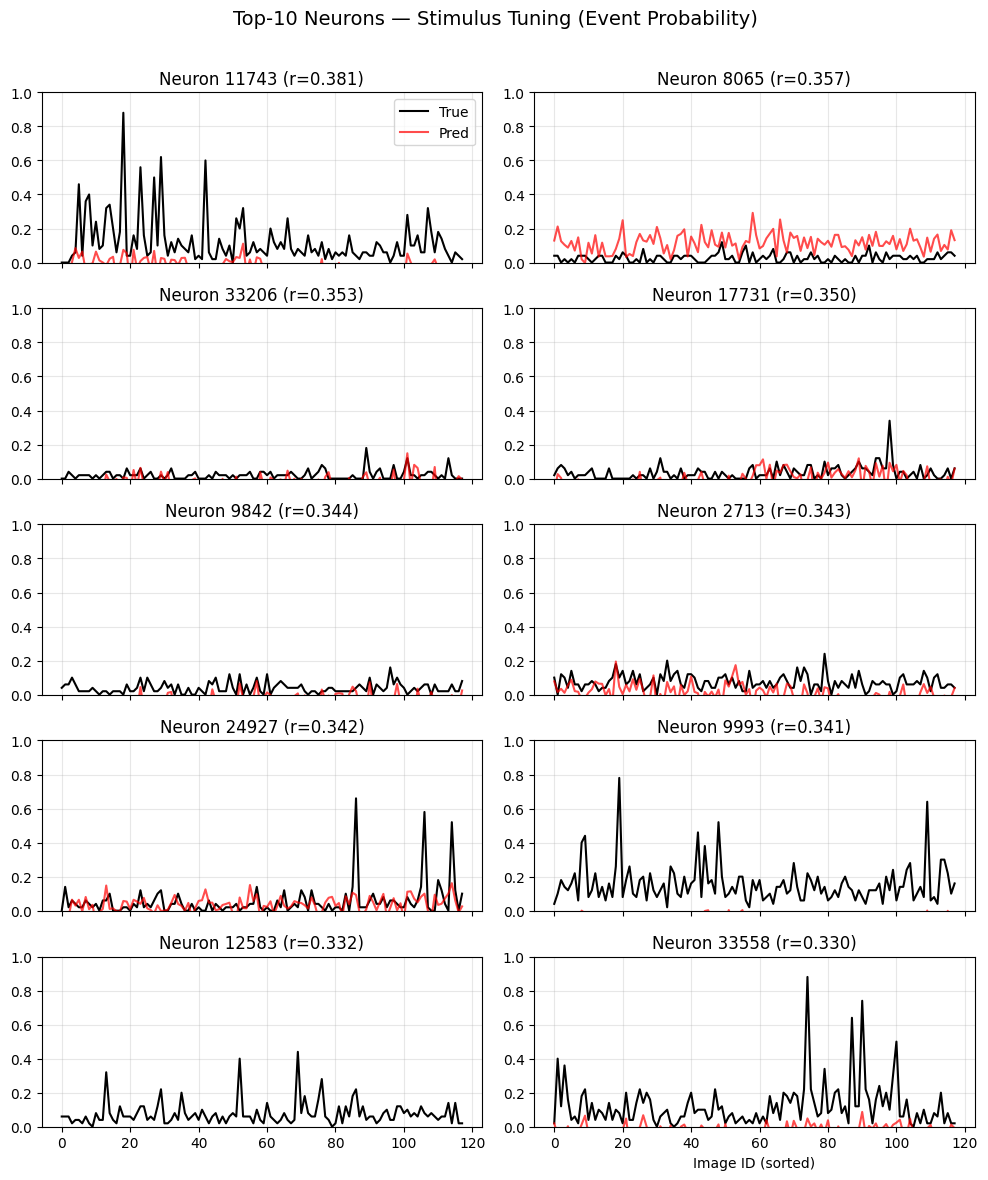

💾 Saved → top10_neuron_tuning_binary.png


In [6]:
# ---------------------------------------------------------------
# PLOT STIMULUS TUNING (Pred vs True) — binary/event neurons
# ---------------------------------------------------------------
fig, axs = plt.subplots(5, 2, figsize=(10, 12), sharex=True)
axs = axs.flatten()

for j, nid in enumerate(top_idx):
    ax = axs[j]
    yt = Y_true[:, nid]   # mean spike probability per image
    yp = Y_pred[:, nid]
    ax.plot(yt, label="True", color="black", linewidth=1.5)
    ax.plot(yp, label="Pred", color="red", alpha=0.7)
    ax.set_ylim(0, max(1.0, yt.max()*1.1))
    ax.set_title(f"Neuron {nid} (r={corrs[nid]:.3f})")
    ax.grid(True, alpha=0.3)
    if j == 0:
        ax.legend()

plt.suptitle("Top-10 Neurons — Stimulus Tuning (Event Probability)", fontsize=14)
plt.xlabel("Image ID (sorted)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("top10_neuron_tuning_binary.png", dpi=200)
plt.show()

print("💾 Saved → top10_neuron_tuning_binary.png")


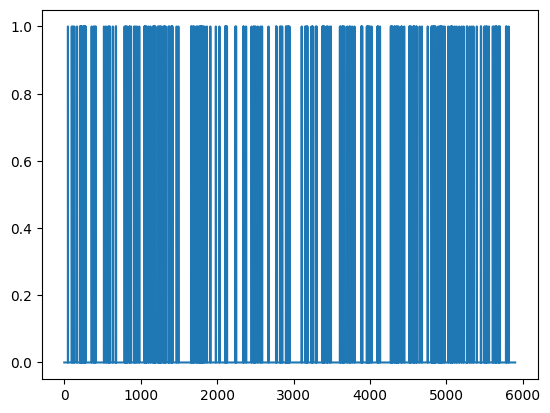

In [8]:
dat=np.load(DATA_PATH)

plt.plot(dat[0])

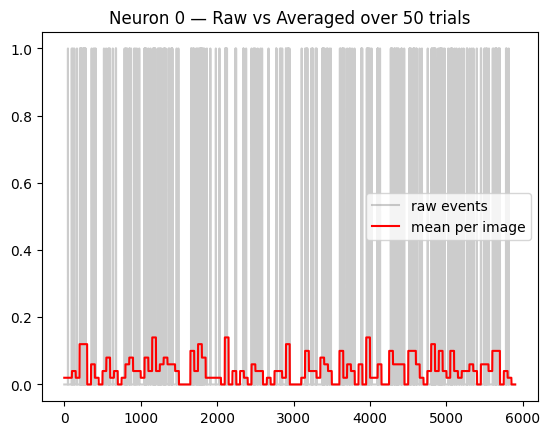

In [9]:
neuron_idx = 0
plt.figure()
plt.plot(dat[neuron_idx], color='gray', alpha=0.4, label='raw events')
plt.plot(np.repeat(Y_image_mean[:, neuron_idx], N_TRIALS), 'r', label='mean per image')
plt.legend()
plt.title(f"Neuron {neuron_idx} — Raw vs Averaged over {N_TRIALS} trials")
plt.show()
